In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from prince import MCA
import math
import conorm
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "../../"))
sys.path.append(os.path.join(os.getcwd(), "../../nextflow"))
from pca_analysis import plot, get_clustermap_genes_by_pathway
import plotly.express as px
from gsmmutils.omics.omics_integration import OmicsIntegration 
from gsmmutils.model.COBRAmodel import MyModel
DATA_PATH = "/home/ecunha/omics-integration/data/dsalina/PRJNA437866"
os.chdir(DATA_PATH)
RESULTS_PATH = "/home/ecunha/omics-integration/results/dsalina/PRJNA437866"
sns.set(rc={'figure.figsize':(7.08,3)})
sns.set_theme(context='paper', palette="colorblind", font='Arial')
plt.rcParams['axes.titlesize'] = 10
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": "Arial",
})
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['font.size'] = 9
plt.rcParams['font.family'] = 'Arial'

In [18]:
template_model = MyModel("../models/model_ds.xml", "e_Biomass__cytop")
omics = OmicsIntegration('raw_counts.txt', samples_names={"SRR6825159_Aligned.sortedByCoord.out.bam": "control_1",
                                                                    "SRR6825160_Aligned.sortedByCoord.out.bam": "control_2",
                                                                    "SRR6825161_Aligned.sortedByCoord.out.bam": "control_3",
                                                                    "SRR6825162_Aligned.sortedByCoord.out.bam": "nacl_1",
                                                                    "SRR6825163_Aligned.sortedByCoord.out.bam": "nacl_2",
                                                                    "SRR6825164_Aligned.sortedByCoord.out.bam": "nacl_3",
                                                                    "SRR6825165_Aligned.sortedByCoord.out.bam": "h2o2_1",
                                                                    "SRR6825166_Aligned.sortedByCoord.out.bam": "h2o2_2",
                                                                    "SRR6825167_Aligned.sortedByCoord.out.bam": "h2o2_3",
                                                                    "SRR6825168_Aligned.sortedByCoord.out.bam": "sorb_1",
                                                                    "SRR6825169_Aligned.sortedByCoord.out.bam": "sorb_2",
                                                                    "SRR6825170_Aligned.sortedByCoord.out.bam": "sorb_3",
                                                                    }, model=template_model)
omics.counts.to_csv("raw_data.tsv", sep="\t")

Loading

Reactions: 4492
Metabolites: 3669
Genes: 1700
Model loaded


In [4]:
template_model = MyModel("../models/model_ds.xml", "e_Biomass__cytop")
omics = OmicsIntegration('merged_featureCounts.tsv', samples_names={"SRR6825159_featureCounts": "control_1",
                                                                    "SRR6825160_featureCounts": "control_2",
                                                                    "SRR6825161_featureCounts": "control_3",
                                                                    "SRR6825165_featureCounts": "h2o2_1",
                                                                    "SRR6825166_featureCounts": "h2o2_2",
                                                                    "SRR6825167_featureCounts": "h2o2_3",
                                                                    }, model=template_model)
omics.counts.to_csv("raw_data_h2o2.tsv", sep="\t")

Loading

Reactions: 4492
Metabolites: 3669
Genes: 1700
Model loaded


In [19]:
omics.getmm = conorm.getmm(pd.concat([omics.counts, omics.data.Length], axis=1), 'Length')
# omics.sum_tech_reps()

In [8]:
omics.getmm = conorm.getmm(pd.concat([omics.counts, omics.data.Length], axis=1), 'Length')
omics.getmm.to_csv("getmm_with_replicates.tsv", sep="\t")

In [21]:
getmm_log2 = omics.getmm.applymap(lambda x: math.log2(x + 1))

<AxesSubplot:ylabel='Density'>

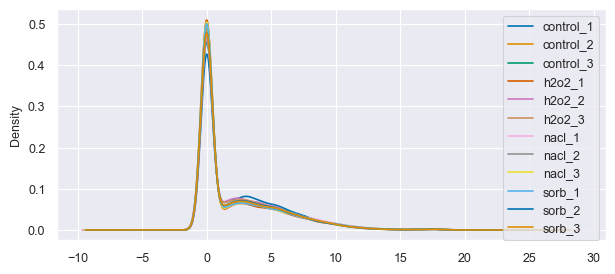

In [22]:
getmm_log2.plot.density()

In [73]:
def plot(components, y, xaxis_title, yaxis_title, filename, legend_title="", additional_shapes=None, annotations=None, color=None,
         width=600, height=360, **kwargs):
    if not additional_shapes:
        additional_shapes = []
    if not annotations:
        annotations = []
    if not color:
        color = y
    fig = px.scatter(x=components[:, 0], y=components[:, 2], color=color, **kwargs)
    fig.update_layout(
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        margin=dict(l=20, r=20, t=20, b=20),
        font=dict(size=kwargs.get('fontsize', 10))
    )
    fig.update_layout(legend_title_text=legend_title, width=width, height=height)
    fig.update_layout(coloraxis_colorbar=dict(title='Threshold', yanchor="top", y=1.02, x=1.20, ticks="outside"))
    for shape in additional_shapes:
        fig.add_shape(
            shape
        )
    for ann in annotations:
        fig.add_annotation(
            ann
        )
    fig.show()
    fig.write_image(f"{filename}.pdf", format="pdf", scale=3)

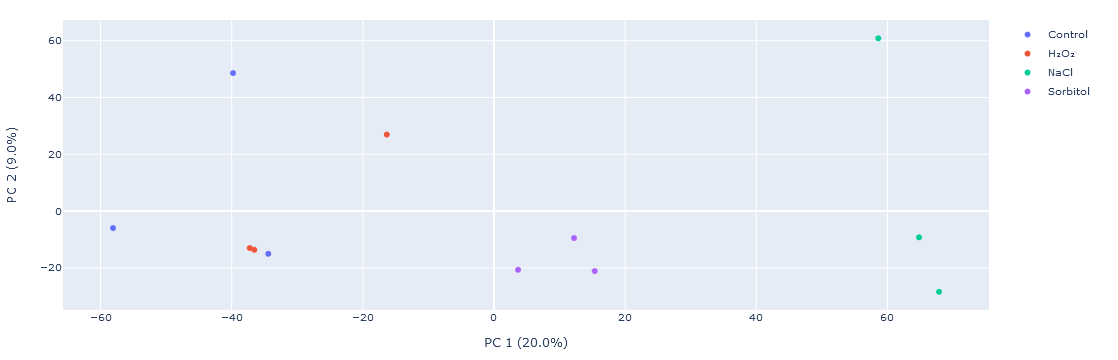

In [74]:
tmp = getmm_log2.T
pca = PCA(n_components=4, random_state=42)
components = pca.fit_transform(tmp)
mapping = {'control': "Control", "h2o2": "H\u2082O\u2082", "nacl": "NaCl", "sorb": "Sorbitol"}

plot(components,[mapping[e.split("_")[0]] for e in tmp.T.columns] ,
    f"PC 1 ({round(pca.explained_variance_ratio_[0], 2) * 100}%)",
    f"PC 2 ({round(pca.explained_variance_ratio_[2], 2) * 100}%)",
    os.path.join(RESULTS_PATH, 'pca_rnaseq_ds'),
)

In [68]:
pca.explained_variance_ratio_

array([0.20141627, 0.12814273, 0.08572137])

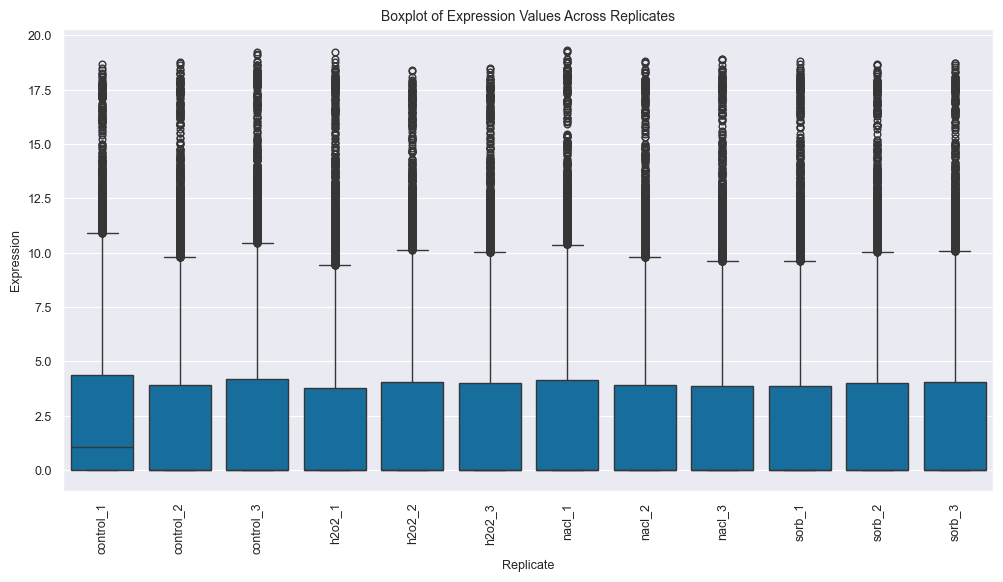

In [24]:
melted_df = getmm_log2.melt(var_name='Replicate', value_name='Expression')

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Replicate', y='Expression', data=melted_df)
plt.xticks(rotation=90)
plt.title('Boxplot of Expression Values Across Replicates')
plt.show()

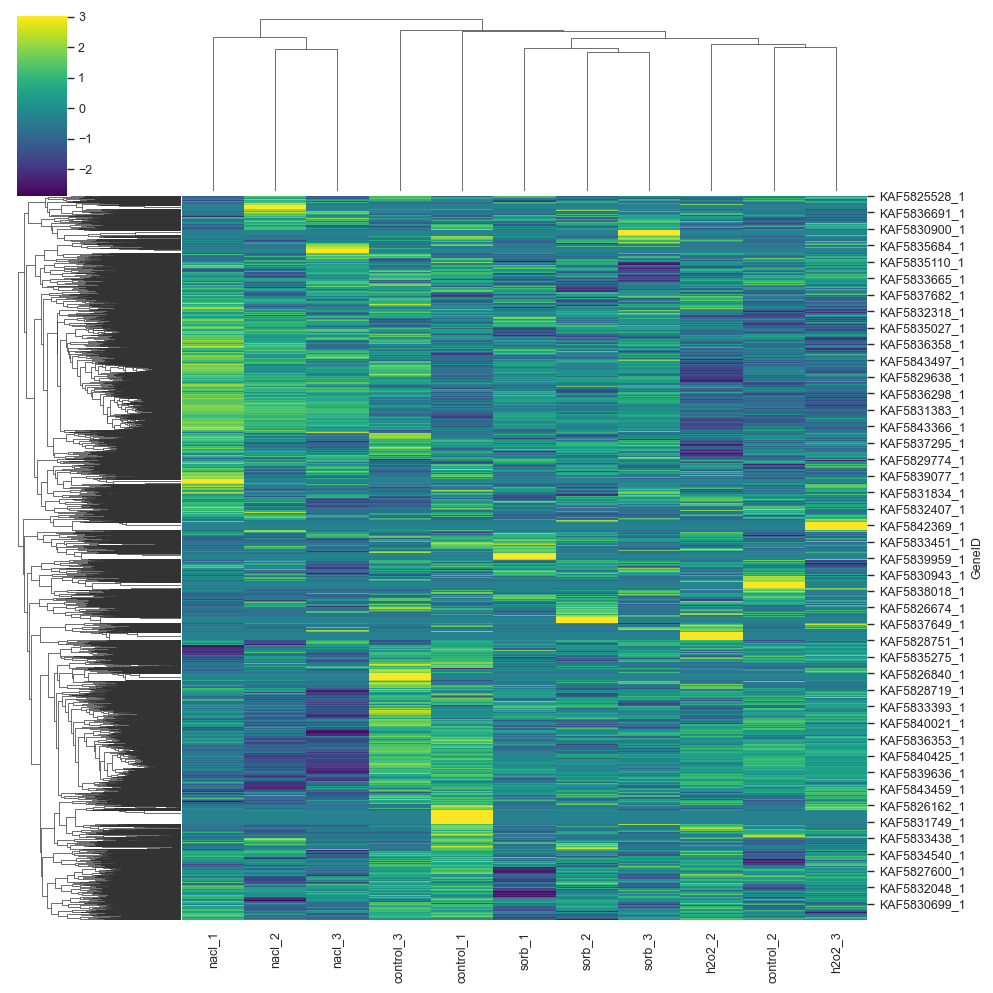

In [55]:
row_std = tmp.T.std(axis=1)
getmm_log2_filt = tmp.T[row_std != 0]
sns.clustermap(getmm_log2_filt, cmap="viridis", z_score=0)

In [13]:
omics.degs = pd.read_csv(os.path.join(RESULTS_PATH, r"deg/degs.tsv"),sep="\t", index_col=0)
omics.degs.index = [e + "_1" for e in omics.degs.index]
# omics.getmm.index = [e + "_1" for e in omics.getmm.index]

/home/ecunha/miniforge3/envs/omics-integration/lib/python3.10/site-packages/gsmmutils-0.0.2-py3.10.egg/gsmmutils/omics/omics_integration.py:143: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ecunha/miniforge3/envs/omics-integration/lib/python3.10/site-packages/gsmmutils-0.0.2-py3.10.egg/gsmmutils/omics/omics_integration.py:143: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/ecunha/miniforge3/envs/omics-integration/lib/python3.10/site-packages/gsmmutils-0.0.2-py3.10.egg/gsmmutils/omics/omics_integ

<AxesSubplot:ylabel='Density'>

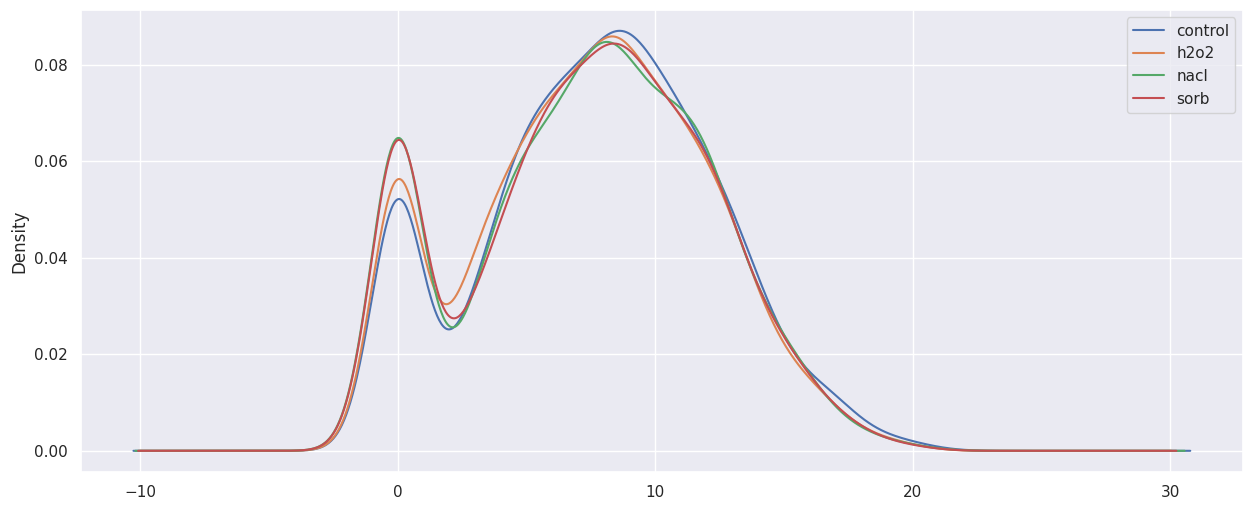

In [8]:
omics.sum_tech_reps()
omics_data = omics.getmm.applymap(lambda x: math.log2(x + 1))
# omics_data.index = [e.replace("-", "_").replace("_1", "") for e in omics_data.index]
omics_data = omics_data.loc[omics_data.index.isin([gene.id for gene in template_model.genes])]
omics_data.plot.density()

In [14]:
get_clustermap_genes_by_pathway(omics, os.path.join(RESULTS_PATH, r"deg/path_by_gene"))